In [1]:
import itertools

import libmambapy

import mamba_error_reporting as mer

# Problem definition

## PubGrub Example

The example given by Natalie Weizenbaum (image credits https://nex3.medium.com/pubgrub-2fb6470504f)

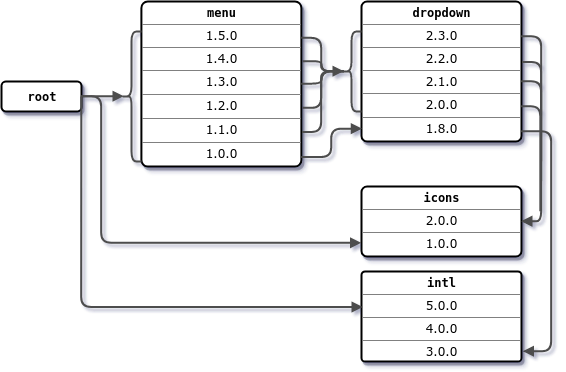

### Ideal output (from PubGrub)
```
Because dropdown >=2.0.0 depends on icons >=2.0.0 and root depends
  on icons <2.0.0, dropdown >=2.0.0 is forbidden.

And because menu >=1.1.0 depends on dropdown >=2.0.0, menu >=1.1.0
  is forbidden.

And because menu <1.1.0 depends on dropdown >=1.0.0 <2.0.0 which
  depends on intl <4.0.0, every version of menu requires intl
  <4.0.0.

So, because root depends on both menu >=1.0.0 and intl >=5.0.0,
  version solving failed.
```

# Conflict analysis

In [2]:
import pandas as pd
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [3]:
solver, pool = mer.problems.create_pubgrub()
success = solver.solve()
if not success:
    print(mer.messaging.old_error_report(solver))

Mamba failed to solve. The reported errors are:
   Encountered problems while solving:
     - package menu-1.0.0 requires dropdown 1.**, but none of the providers can be installed
   


In [4]:
pbs = mer.analysis.all_problems_structured_df(solver)
deps = mer.analysis.select_solvables_df(
    pool, pbs[~pbs.dependency.isnull()].dependency_id.drop_duplicates()
)
solvables = mer.analysis.id_to_pkg_info_df(pool,
    itertools.chain(
    pbs[pbs.source_is_pkg].source_id,
    pbs[pbs.target_is_pkg].target_id,
    deps.solvable_id
)).drop_duplicates().set_index('id').sort_index()

In [5]:
pbs

,type,source_id,source_is_pkg,dependency,dependency_id,target_id,target_is_pkg,explanation
0,SolverRuleinfo.SOLVER_RULE_JOB,0,False,menu,203,259,False,conflicting requests
1,SolverRuleinfo.SOLVER_RULE_PKG_REQUIRES,7,True,dropdown 1.**,-2147483641,0,False,"package menu-1.0.0 requires dropdown 1.**, but..."
2,SolverRuleinfo.SOLVER_RULE_PKG_REQUIRES,2,True,dropdown 2.**,-2147483647,0,False,"package menu-1.5.0 requires dropdown 2.**, but..."
3,SolverRuleinfo.SOLVER_RULE_PKG_REQUIRES,3,True,dropdown 2.**,-2147483647,0,False,"package menu-1.4.0 requires dropdown 2.**, but..."
4,SolverRuleinfo.SOLVER_RULE_PKG_REQUIRES,4,True,dropdown 2.**,-2147483647,0,False,"package menu-1.3.0 requires dropdown 2.**, but..."
5,SolverRuleinfo.SOLVER_RULE_PKG_REQUIRES,5,True,dropdown 2.**,-2147483647,0,False,"package menu-1.2.0 requires dropdown 2.**, but..."
6,SolverRuleinfo.SOLVER_RULE_PKG_REQUIRES,6,True,dropdown 2.**,-2147483647,0,False,"package menu-1.1.0 requires dropdown 2.**, but..."
7,SolverRuleinfo.SOLVER_RULE_PKG_REQUIRES,12,True,intl 3.**,-2147483633,0,False,"package dropdown-1.8.0 requires intl 3.**, but..."
8,SolverRuleinfo.SOLVER_RULE_PKG_REQUIRES,8,True,icons 2.**,-2147483639,0,False,"package dropdown-2.3.0 requires icons 2.**, bu..."
9,SolverRuleinfo.SOLVER_RULE_PKG_REQUIRES,9,True,icons 2.**,-2147483639,0,False,"package dropdown-2.2.0 requires icons 2.**, bu..."


In [6]:
deps

,dependency_id,solvable_id
0,203,2
1,203,3
2,203,4
3,203,5
4,203,6
5,203,7
6,-2147483641,12
7,-2147483647,8
8,-2147483647,9
9,-2147483647,10


In [7]:
solvables

,name,version,build_string,build_number
id,,,,
2,menu,1.5.0,,0
3,menu,1.4.0,,0
4,menu,1.3.0,,0
5,menu,1.2.0,,0
6,menu,1.1.0,,0
7,menu,1.0.0,,0
8,dropdown,2.3.0,,0
9,dropdown,2.2.0,,0
10,dropdown,2.1.0,,0


In [8]:
def build_problem_graph_solvable(pbs, solvables, deps):
    g = nx.DiGraph()
    
    # All solvables
    for solv_id, solv_info in solvables.iterrows():
        g.add_node(solv_id, **solv_info)
       
    # TODO include other JOBs
    # TODO figure what to do with dependency with null source
    pbs_with_deps = pbs[pbs.type.isin([libmambapy.SolverRuleinfo.SOLVER_RULE_PKG_REQUIRES])]
    pbs_with_deps = pbs_with_deps.join(deps.set_index("dependency_id"), on="dependency_id")
    
    # All dependency edges
    for _, pb in pbs_with_deps.iterrows():
        g.add_edge(
            pb.source_id, pb.solvable_id,
            dependency_id=pb.dependency_id, dependency=pb.dependency
        )

    return g

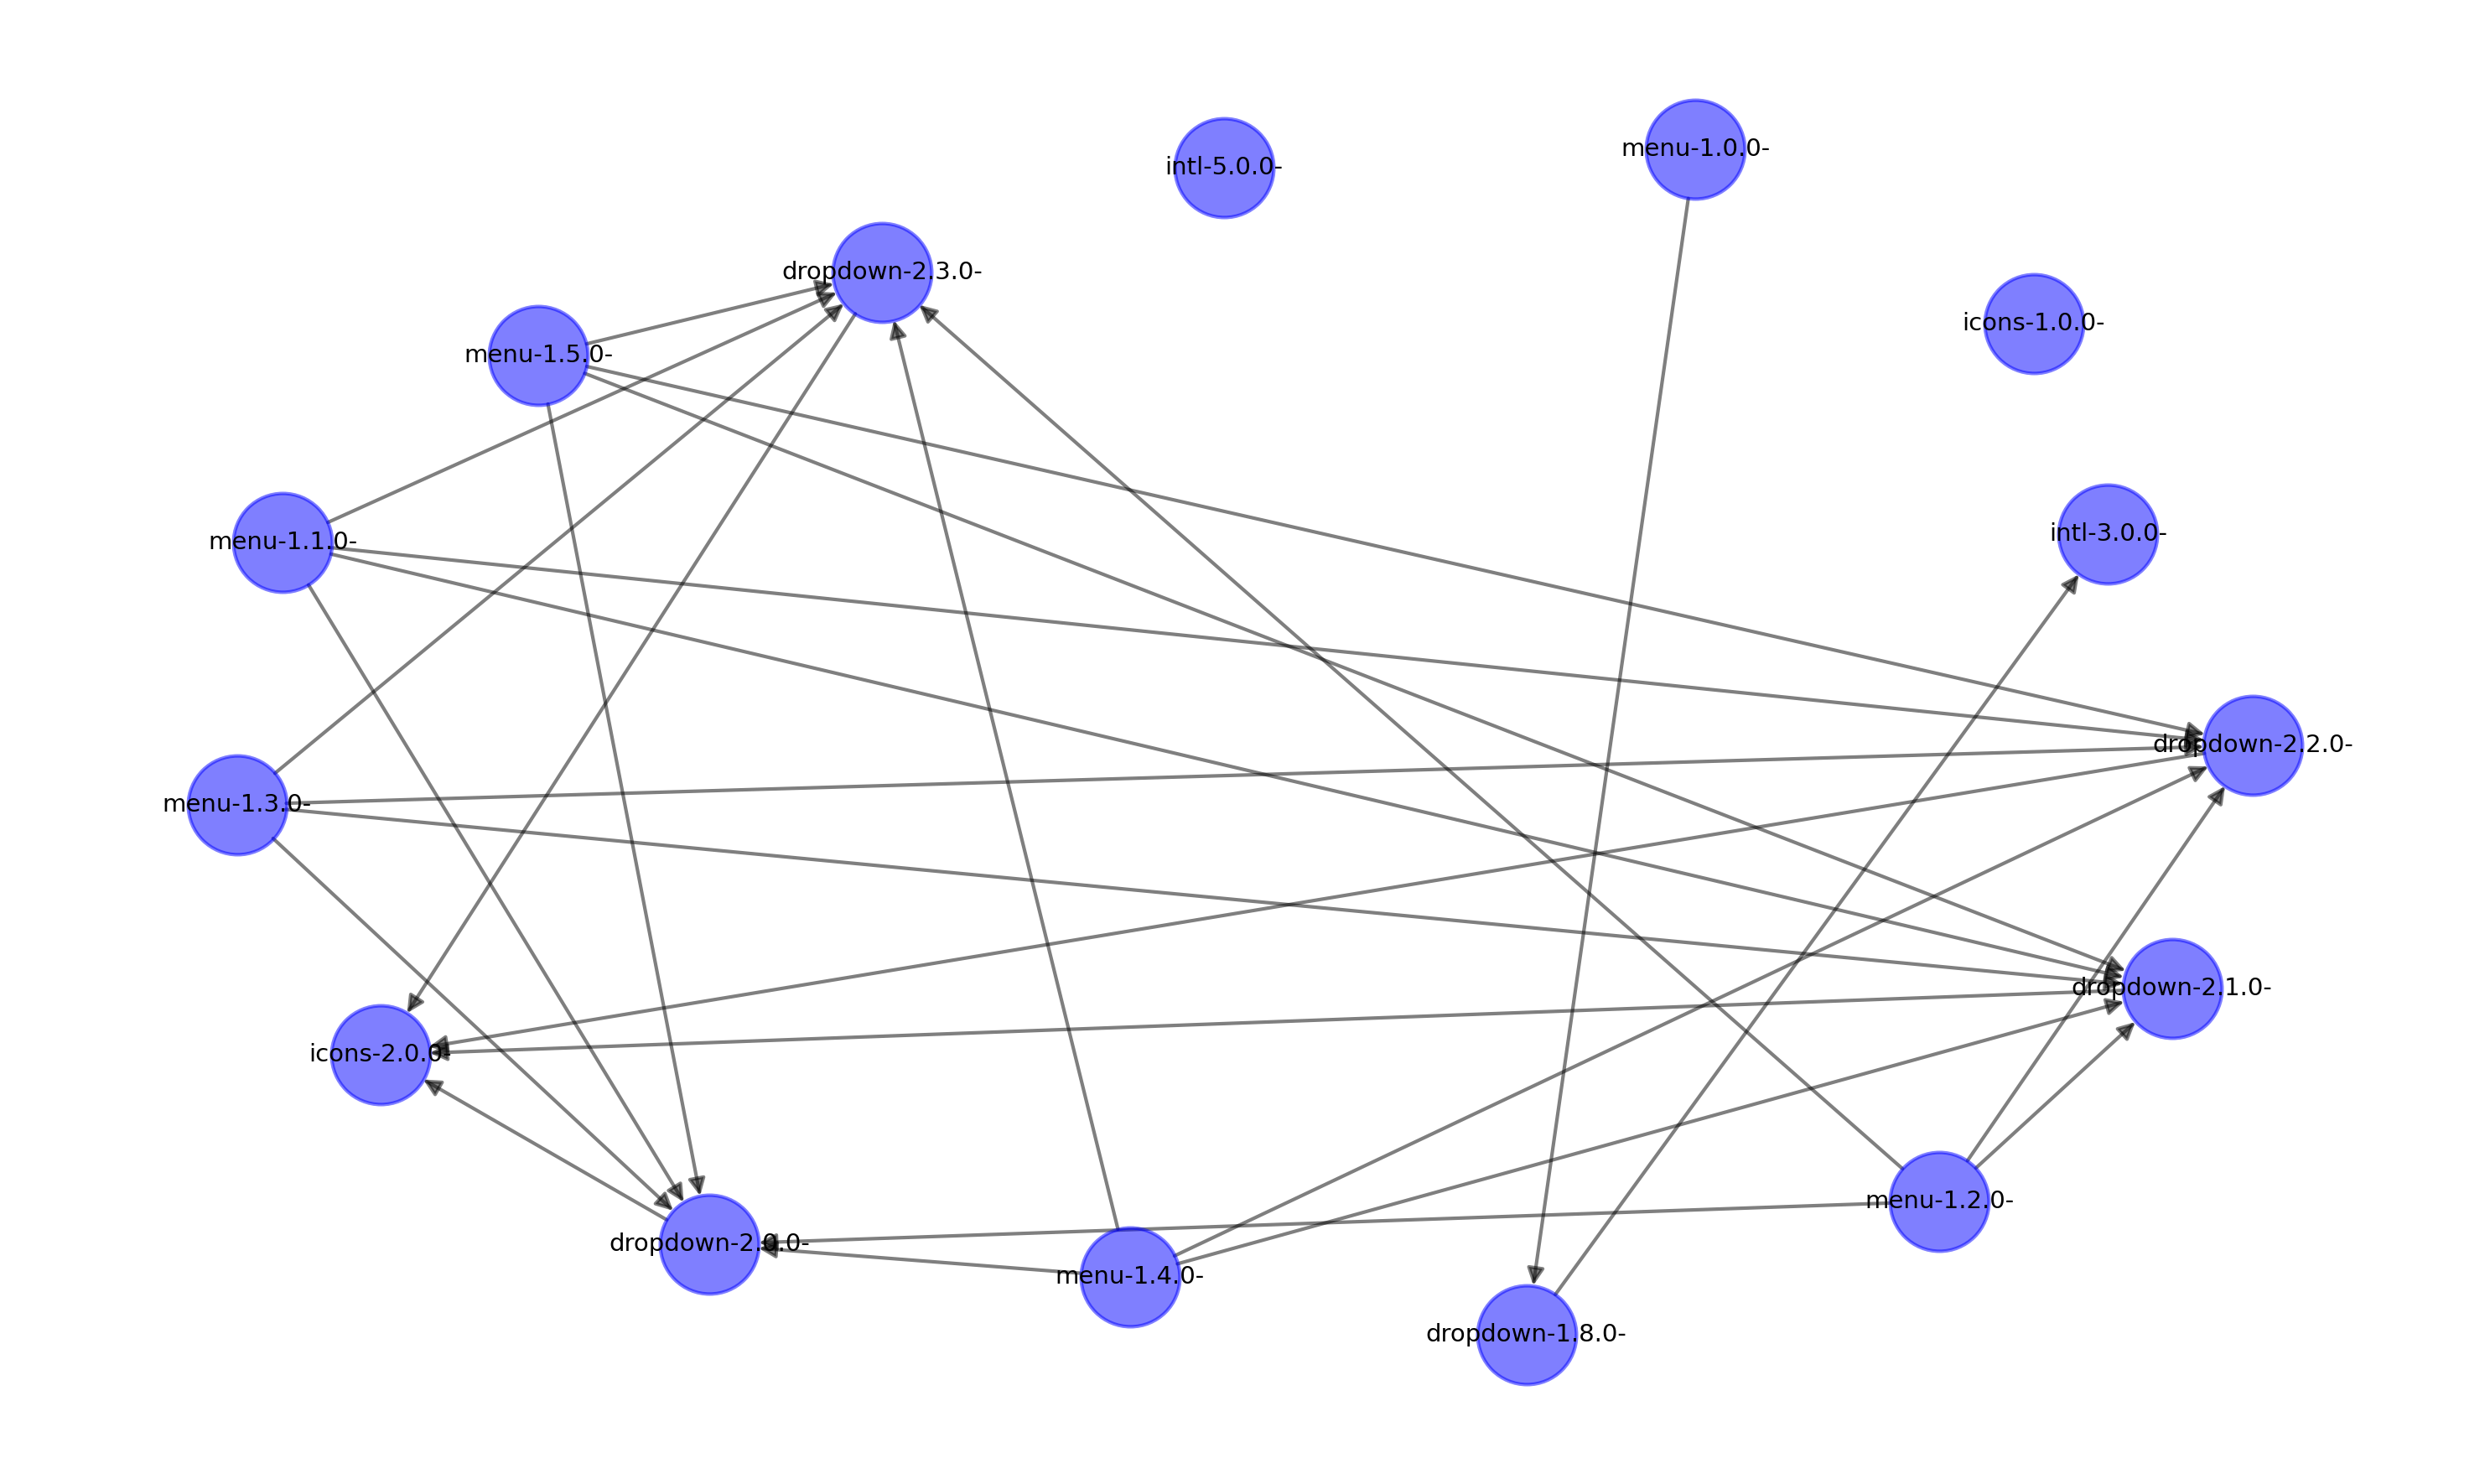

In [9]:
g = build_problem_graph_solvable(pbs, solvables, deps)

plt.figure(figsize=(10, 6), dpi=300)

pos = nx.spring_layout(g, k=5)

options = {"node_size": 800, "alpha": 0.5}

nx.draw_networkx_nodes(g, pos, node_color="blue", **options)
nx.draw_networkx_edges(g, pos, **options)

# some labels
labels = {n: "{name}-{version}-{build_string}".format(**attr) for n, attr in g.nodes.items()}
# nx.draw_networkx_labels(g, pos, labels, font_size=22, font_color="whitesmoke")
nx.draw_networkx_labels(g, pos, labels, font_size=7)

plt.tight_layout()
plt.axis("off")
plt.show()

In [10]:
def get_root_ancestor(graph, node):
    root_parents = set()
    visited = {node}
    while len(visited) > 0:
        n = visited.pop()
        parents = set(graph.predecessors(n))
        if len(parents) > 0:
            visited = visited.union(parents)
        else:
            root_parents.add(n)
    return root_parents

            
def explain_errors(graph):
    # leaves = [n for n in graph.nodes() if graph.in_degree(n) >= 1]
    leaves = [n for n in graph.nodes() if graph.out_degree(n) == 0 and graph.in_degree(n) >= 1]

    # print([str(graph.nodes[l]["pkg_info"]) for l in leaves])
    conflicts = {}
    for leaf in leaves:
        leaf_pkg_repr = "{name}-{version}-{build_string}".format(**graph.nodes[leaf])
        leaf_in_dependencies = set(
            graph.edges[e]["dependency"] for e in graph.in_edges(leaf)
        )
        
        ancestors = get_root_ancestor(graph, leaf)
        ancestor_pkg_repr = ["{name}-{version}-{build_string}".format(**graph.nodes[n]) for n in ancestors]
        ancestor_out_dependencies = set(
            graph.edges[e]["dependency"] for a in ancestors for e in graph.out_edges(a) 
        )
        print(f"Leaf: {leaf_pkg_repr}")
        print("  has dependencies " + " & ".join(leaf_in_dependencies))
        print(f"Ancestor: " + ", ".join(ancestor_pkg_repr))
        print("  has dependencies " + " & ".join(ancestor_out_dependencies))
        print()

In [11]:
explain_errors(g)

Leaf: icons-2.0.0-
  has dependencies icons 2.**
Ancestor: menu-1.5.0-, menu-1.4.0-, menu-1.3.0-, menu-1.2.0-, menu-1.1.0-
  has dependencies dropdown 2.**

Leaf: intl-3.0.0-
  has dependencies intl 3.**
Ancestor: menu-1.0.0-
  has dependencies dropdown 1.**

